In this notebook, we'll take a look at a couple of examples to illustrate the importance of initialization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We're going to work with 512 input neurons. We'll assume these are preprocessed so that they behave according to a normal distribution. It doesn't matter what the inputs are, so we'll just randomly set them.

In [2]:
num_inputs = 512

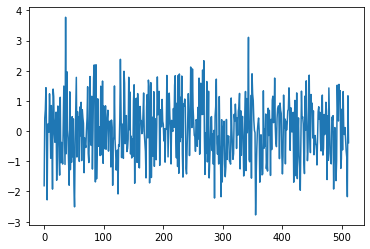

In [3]:
inputs = np.random.normal(size=num_inputs)
plt.plot(inputs)

Next' let us assume we're working with a deep neural network, one containing 100 layers.

For simplicity's sake, we'll also assume we're using 512 hidden neurons in every layer.

In [4]:
num_layers  = 100
num_outputs = 512

We can then easily keep track of the activations as we go through the layers. For now, we're not using any activation function, so the activation can be calculated by means of a simple matrix multiplication (the `@` operator in Python/Numpy).

Let's see what happens if we assume the weights to be initialized using a normal distribution as well...

In [5]:
activations = [inputs]

for i in range(num_layers):
  weights = np.random.normal(size=(len(activations[-1]), num_outputs))
  activations.append(activations[-1] @ weights)

print('Mean and standard deviation of activations in last layer:', 
      np.mean(activations[-1]), np.std(activations[-1]))

Mean and standard deviation of activations in last layer: -4.3235651614316437e+133 1.6728391590957332e+135


Did you see what is happening here? The activations are blowing up! The blowup also happens very fast, e.g. already in the first couple of layers:

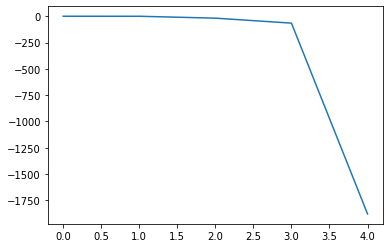

In [6]:
plt.plot([np.mean(layer) for layer in activations[:5]])

This will certainly not make our network train well, so let's try to fix this. Obviously, we could simply try to scale down the weights to a smaller number.

In [7]:
scale_factor = 0.001

activations = [inputs]

for i in range(num_layers):
  weights = np.random.normal(size=(len(activations[-1]), num_outputs)) * scale_factor
  activations.append(activations[-1] @ weights)

print('Mean and standard deviation of activations in last layer:', 
      np.mean(activations[-1]), np.std(activations[-1]))

Mean and standard deviation of activations in last layer: -6.4572992822505606e-167 0.0


Yikes, now our activations are vanishing, and all their variation is gone (most likely leading to vanishing gradients if we would try to train this network).

Let's try to approach the problem a bit more formally. Recall that we're taking a matrix product between incoming inputs and the weight matrix. Given that we have initialized these from a standard normal distribution, we know that this matrix product will have a standard deviation very close to the square root of the number of input connections. In fact, let's verify this ourselves:

In [8]:
weights    = np.random.normal(size=(len(inputs), num_outputs))
activation = inputs @ weights

print('Mean:', np.mean(activation))
print('Std.:', np.std(activation))
print('sqrt(len(inputs)):', np.sqrt(len(inputs)))

Mean: 0.33587919042682063
Std.: 22.30229717576446
sqrt(len(inputs)): 22.627416997969522


This is why we see our outputs exploding.

What we would actually like is for each layer's activation distribution to have standard deviation of about 1, and the mean centered at zero, i.e. have all the activations be normal distributed as well.

Note: initialization will help a lot here, but the criteria above also highlights why batch normalization works so well, as we will discuss later on.

So let us try by scaling the weights by dividing them by the square root of the inputs.

In [9]:
activations = [inputs]

for i in range(num_layers):
  weights = np.random.normal(size=(len(activations[-1]), num_outputs)) / np.sqrt(len(activations[-1]))
  activations.append(activations[-1] @ weights)

print('Mean and standard deviation of activations in last layer:', 
      np.mean(activations[-1]), np.std(activations[-1]))

Mean and standard deviation of activations in last layer: 0.020406806125856342 0.9759261302037492


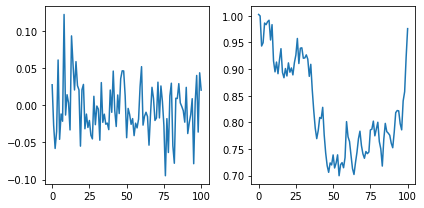

In [10]:
fix, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot([np.mean(layer) for layer in activations])
ax[1].plot([np.std(layer) for layer in activations])
plt.tight_layout()

This is already way better. However, one thing we didn't do yet is introduce an activation function, so let us see what happens if we use e.g. `tanh` in each layer...

In [11]:
act_func = np.tanh

In [12]:
activations = [inputs]

for i in range(num_layers):
  weights = np.random.normal(size=(len(activations[-1]), num_outputs)) / np.sqrt(len(activations[-1]))
  activation = act_func(activations[-1] @ weights)
  activations.append(activation)

print('Mean and standard deviation of activations in last layer:', 
      np.mean(activations[-1]), np.std(activations[-1]))

Mean and standard deviation of activations in last layer: 0.0002883796990582805 0.06859700535658105


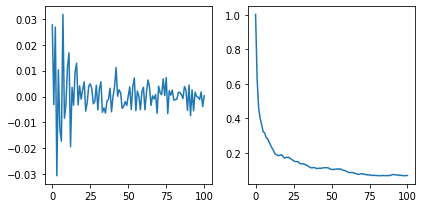

In [13]:
fix, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot([np.mean(layer) for layer in activations])
ax[1].plot([np.std(layer) for layer in activations])
plt.tight_layout()

The problem is not as pronounced, but we do see that the variation in our activations are vanishing away as we progress through the layer.

We can see what happens if we use a uniform initalization instead...

In [14]:
activations = [inputs]

for i in range(num_layers):
  weights = np.random.uniform(-1, 1, size=(len(activations[-1]), num_outputs)) / np.sqrt(len(activations[-1]))
  activation = act_func(activations[-1] @ weights)
  activations.append(activation)

print('Mean and standard deviation of activations in last layer:', 
      np.mean(activations[-1]), np.std(activations[-1]))

Mean and standard deviation of activations in last layer: -2.3403782054494808e-26 7.612826544584287e-25


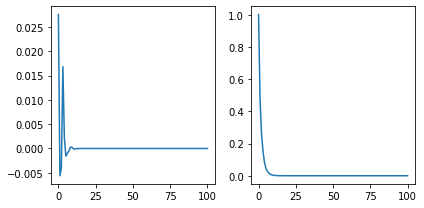

In [15]:
fix, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot([np.mean(layer) for layer in activations])
ax[1].plot([np.std(layer) for layer in activations])
plt.tight_layout()

Yikes, this is even worse!

As easy as this is to emprically validate, it is quite remarkable that as recently as 2010, the above was the convential approach for initializating weights, until Xavier Glorot and Yoshua Bengio published their landmark paper "Understanding the difficulty of training deep feedforward neural networks".

In this paper, they propose to initialize weights by drawing from a distribution with zero mean and a variance equal to one over the number of input units and output units. They call this "Normalized initialized" and is often referred to as "Xavier initialization" as well.

Let's try to do this.

In [16]:
activations = [inputs]

for i in range(num_layers):
  xavier  = np.sqrt(len(activations[-1]) + num_outputs)
  weights = np.random.normal(size=(len(activations[-1]), num_outputs), scale=xavier)
  activation = act_func(activations[-1] @ weights)
  activations.append(activation)

print('Mean and standard deviation of activations in last layer:', 
      np.mean(activations[-1]), np.std(activations[-1]))

Mean and standard deviation of activations in last layer: 0.00025197974199888534 0.9997642117488723


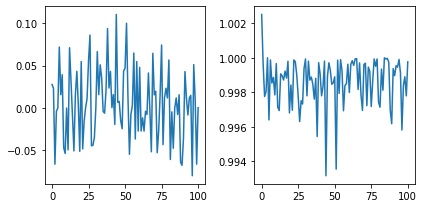

In [17]:
fix, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot([np.mean(layer) for layer in activations])
ax[1].plot([np.std(layer) for layer in activations])
plt.tight_layout()

However, let us now see what happens when we try a ReLU activation function.

In [18]:
act_func = lambda x : np.maximum(x, 0)

In [19]:
activations = [inputs]

for i in range(num_layers):
  weights = np.random.normal(size=(len(activations[-1]), num_outputs),
                             scale=np.sqrt(len(activations[-1]) + num_outputs))
  activation = act_func(activations[-1] @ weights)
  activations.append(activation)

print('Mean and standard deviation of activations in last layer:', 
      np.mean(activations[-1]), np.std(activations[-1]))

Mean and standard deviation of activations in last layer: 5.984394601881836e+270 inf


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


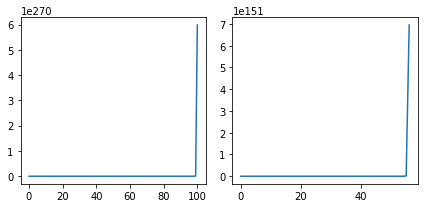

In [20]:
fix, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot([np.mean(layer) for layer in activations])
ax[1].plot([np.std(layer) for layer in activations])
plt.tight_layout()

Again, this is not what we want. Enter another paper, "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification" by Kaiming He et al. They simply propose to initialize the weights using a Gaussian distribution with a standard deviation of $\sqrt{2/n_i}$.

In [25]:
activations = [inputs]

for i in range(num_layers):
  kaiming = np.sqrt(2) / np.sqrt(len(activations[-1]))
  weights = np.random.normal(size=(len(activations[-1]), num_outputs), scale=kaiming)
  activation = act_func(activations[-1] @ weights)
  activations.append(activation)

print('Mean and standard deviation of activations in last layer:', 
      np.mean(activations[-1]), np.std(activations[-1]))

Mean and standard deviation of activations in last layer: 0.3811332972707188 0.5429568289270164


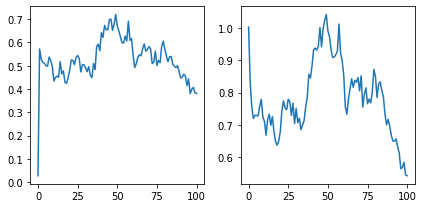

In [26]:
fix, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].plot([np.mean(layer) for layer in activations])
ax[1].plot([np.std(layer) for layer in activations])
plt.tight_layout()

Thanks to this initalization procedure, we have something which remains more stable over the layers, and will improve training of deeper neural networks.